# TP Bayes

## Imports

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import math
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import itertools

## Dataset
* Load iris dataset.
* Using the function cut() and numpy.concatenate(), unbalance the dataset (keep 100% of class 0, 50% of class 1, 33% of class 2)
* Split in train/test.

In [2]:
# Retourne une fraction de X et y en fonction de la classe c
# De plus, ne garde que 1/step enregistrements, coupés régulièrement
def cut(X, y, c, step):
    return X[np.where(y[...]==c)][::step], y[y==c][::step]

In [3]:
iris = datasets.load_iris()
X_all = iris.data
y = iris.target

# Verify datas structures
print(X_all.shape) # (150, 4)
print(y.shape) # (150,)
print(np.unique(y)) # [0 1 2]

X_u_1, y_u_1 = cut(X_all, y, 0 ,1)
X_u_2, y_u_2 = cut(X_all, y, 1 ,2)
X_u_3, y_u_3 = cut(X_all, y, 2 ,3)

X_u_all = np.concatenate((X_u_1,X_u_2,X_u_3))
y_u_all = np.concatenate((y_u_1,y_u_2,y_u_3))
       
print(X_u_all.shape) # (92, 4)
print(y_u_all.shape) # (92,)
# print(X_u_all)
print(y_u_all) # [50 X 0, 25 X 1, 17 X 2]

(150, 4)
(150,)
[0 1 2]
(92, 4)
(92,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [4]:
# Split datas in 2 parts (80% for trainning/validation and 20% for test)
X_train, X_test, y_train, y_test = train_test_split(X_u_all, y_u_all, test_size=0.2, random_state=42, shuffle=True, stratify=y_u_all)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(73, 4)
(73,)
(19, 4)
(19,)


# Summarize data

### Separate data by class
Create a function to separate data by class, and use it

In [5]:
def split_by_class(X,y,c):
    return cut(X,y,c,1)

### Summarize dataset
For each classes, calculate the mean and the standard deviation for each features.
Store it in a structure like this:

    {
        class: [(mean 1st feature, std 1st feature), (mean 2nd feature, std 2nd feature), ...],
        class: [...],
        ...
    }
    
### Notice:
I use only train set (80%) for calculate mean and standard deviation


In [6]:
stats={}

# to compute priori probability later ...
nb_row_class = [] 
nb_row = len(X_train)

for c in np.unique(y):
    X_u_c_0, y_u_c_0 = split_by_class(X_train,y_train,c)
    nb_row_class.append(len(X_u_c_0))
    stats[c] = [(np.mean(x),np.std(x)) for x in zip(*X_u_c_0)]

print(stats)

{0: [(4.9850000000000012, 0.3045898882103607), (3.4025000000000007, 0.39590876474258563), (1.48, 0.1584297951775486), (0.2525, 0.11616260155488943)], 1: [(6.0099999999999998, 0.54945427471264618), (2.7400000000000002, 0.34842502780368689), (4.2649999999999997, 0.50027492441656518), (1.3400000000000003, 0.20099751242241781)], 2: [(6.4615384615384626, 0.73016169077441762), (3.0461538461538464, 0.33423939972923733), (5.5615384615384613, 0.5942525512562451), (2.1769230769230772, 0.23908108104492387)]}


## Prediction
To make a prediction, we need to calculate the probability that a given sample belong to each class, and select the class with the highest probability.

### Compute probability

Use the formula of the Univariate Gaussian distribution presented in the slides, and create a function to estimate the probability.

In [7]:
def compute_probability(x, mean, std):
    return 1/(math.pow((2*math.pi*std),0.5))*math.exp(-((x-mean)*(x-mean))/(2*std))

In [8]:
# Verify your probability function
x = 10
mean = 10
stdev = 1
probability = compute_probability(x, mean, stdev)

print(probability) # Should be 0.3989422804014327

0.3989422804014327


**Q1:** What other methods could you use to compute a probability estimation?

A) In Gaussian family:

    1.Univariate Gaussian distribution (see above)
    2.Multivariate Gaussian distribution
    3.Univariate Gaussian Mixtures
    4.Multivariate Gaussian Mixtures - GMMs
 
B) Histograme:

    1. Return probability value for one value of one feature to be a certain class

### Compute class probabilities
To compute the class probability of a sample, we multiply together the feature probabilities for this class.

In [9]:
# to avoid literals
mean = 0
std = 1

probabilities={}

# for all rows (0 to nbRows-1)
for row in range(len(X_test)):
    # for all classes [0 1 2]
    cls={}
    for classe in np.unique(y_test):
        probabilityClasse = 1.0
        
        #for all features [0 1 2 3]
        for feature in range(len(X_test[row])):
            prb = compute_probability(X_test[row][feature], stats[classe][feature][mean], stats[classe][feature][std])
            probabilityClasse = probabilityClasse * prb
            
        cls[classe] = probabilityClasse * nb_row_class[classe]/nb_row
    
    probabilities[row] = cls
    
#print(probabilities)

### Find the best class

In [10]:
def getBestClasse(row):
    proba = row[0]
    classe = 0
    for i in range(len(row)):
        if row[i] > proba:
            proba = row[i]
            classe = i
            
    return classe

In [11]:
y_pred = []
for row in range(len(X_test)):
    best = getBestClasse(probabilities[row])
    y_pred.append(best)
    #print("Best classe for sample %d = %d (y = %d)" % (row,best, y_test[row]))
    


## Test
Compute the accuracy of your classifier applied to your test set.

In [12]:
#print(y_test)
#print(y_pred)

accuracy = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
print("Accuracy = %0.2f" % (accuracy))

Accuracy = 0.89


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


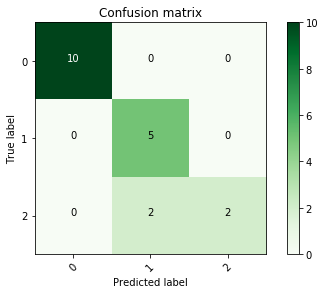

In [14]:
cm = metrics.confusion_matrix(y_test, y_pred)
cls = np.unique(y_test)
plot_confusion_matrix(cm,cls,title='Confusion matrix',cmap=plt.cm.Greens)

### Optional: use cross-validation

### Use the scikit-learn Gaussian Naive Bayes implementation and compare the results

Accuracy = 0.95
Confusion matrix, without normalization


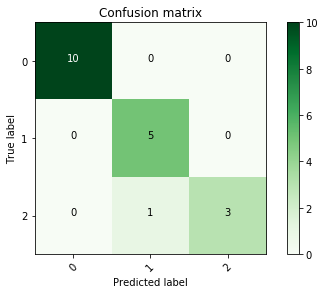

In [15]:
gnb = GaussianNB([nb_row_class[0]/nb_row, nb_row_class[1]/nb_row, nb_row_class[2]/nb_row])
y_pred = gnb.fit(X_train, y_train).predict(X_test)


accuracy = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
print("Accuracy = %0.2f" % (accuracy))

cm = metrics.confusion_matrix(y_test, y_pred)
cls = np.unique(y_test)
plot_confusion_matrix(cm,cls,title='Confusion matrix',cmap=plt.cm.Greens)

Il est interessant de remarquer que les erreurs se situent sur les classes qui ont été déséquilibrées (2 erreurs pour la version a la main et 1 erreur pour la version GaussianNB). 

La prédiction est "poussée" vers les classes qui sont le plus présentent, ce qui rejoint la théorie.

## Plot the distribution
For each class, and for each feature, plot the histogram of the data.

c:\users\jeangera.pont\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
c:\users\jeangera.pont\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  app.launch_new_instance()


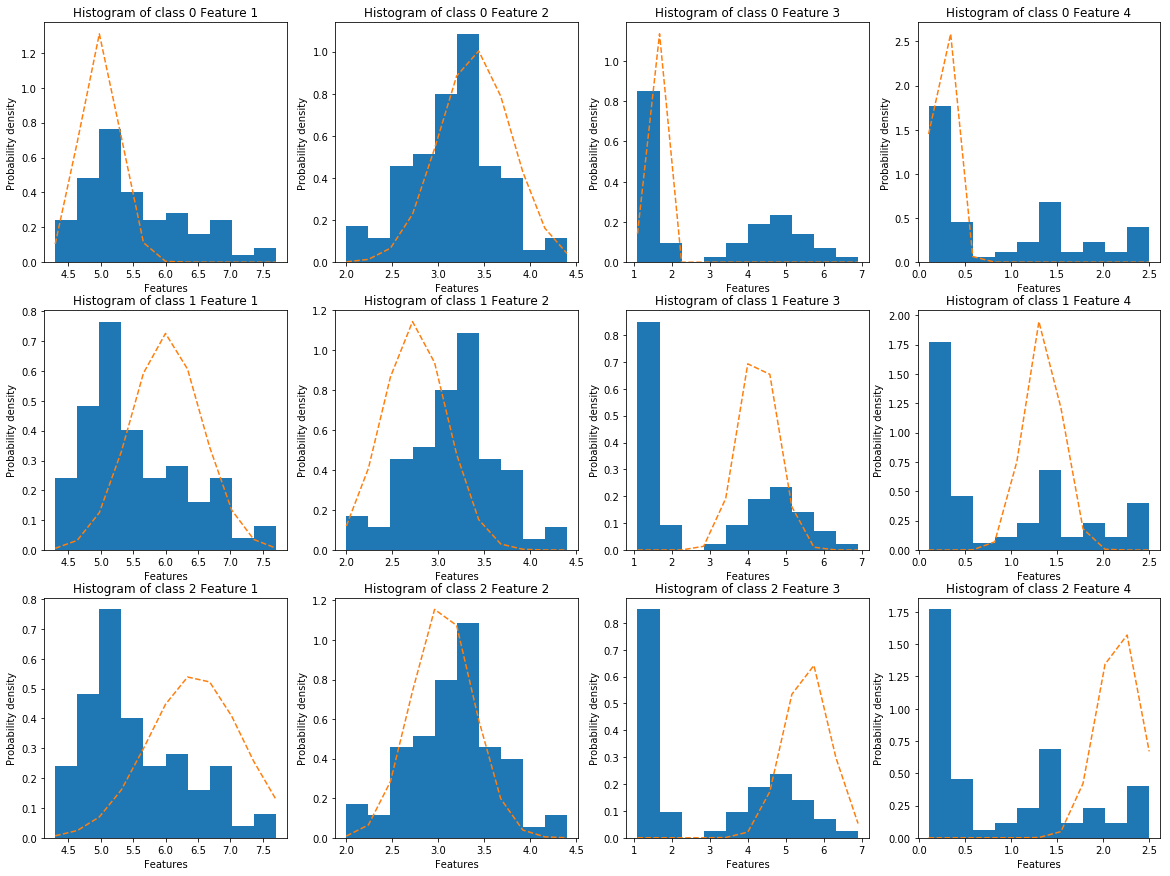

In [16]:
num_plot = 0
fig = plt.figure(figsize=(20,15))
for c in np.unique(y_test):
    for f in [0,1,2,3]:
        num_plot += 1
        mu = stats[c][f][mean] # mean of distribution
        sigma = stats[c][f][std] # standard deviation of distribution
        
        x = list(zip(*X_train))[f] # colonne for one feature
        
        ax = fig.add_subplot(3,4,num_plot)
        
        # The histogram of the data
        n, bins, patches = ax.hist(x, 10, normed=True)

        y_plot = mlab.normpdf(bins, mu, sigma)
        ax.plot(bins, y_plot, '--')
        ax.set_xlabel('Features')
        ax.set_ylabel('Probability density')
        ax.set_title(r'Histogram of class '+ str(c) +' Feature ' + str(f+1))


Based on the histograms, find which feature you think have the most Gaussian distribution.

Do the classification with only one feature (for each features).

Verify if the feature you chose is the one that gives you the best result.

Remarque:

La feature 2 pour les 3 classes montrent les meilleures distributions et se raprochent le plus d'une Gaussienne idéale.

In [17]:
mean = 0
std = 1
probabilities_2={}

# for all rows (0 to nbRows-1)
for row in range(len(X_test)):
    # for all classes [0 1 2]
    cls={}
    for classe in np.unique(y_test):
        probabilityClasse = 1.0
        
        #for features 2 (index 1)
        prb = compute_probability(X_test[row][1], stats[classe][1][mean], stats[classe][1][std])
        probabilityClasse = probabilityClasse * prb
            
        cls[classe] = probabilityClasse * nb_row_class[classe]/nb_row
    
    probabilities_2[row] = cls

In [18]:
y_pred_2 = []
for row in range(len(X_test)):
    best = getBestClasse(probabilities_2[row])
    y_pred_2.append(best)

In [19]:
accuracy = accuracy_score(y_test, y_pred_2, normalize=True, sample_weight=None)
print("Accuracy = %0.2f" % (accuracy))

Accuracy = 0.58


**Q2:** What happens if the distribution is not Gaussian at all? What would you do in this situation?

La fonction de distribution ne permettra pas un bon calcul de la probabilité p(x|Ck)

Une solution consiste à utiliser un histogramme directement (en fonction de x on renvoi la valeur y correspondant à l'histogramme.

Si le profil de l'histogramme montre une serie de bosses, utiliser Univariate Gaussian Mixtures pourrait aussi être une solution.

## Optional: Use histograms as likelihood estimator

Try to replace the univariate gaussian with a solution based on histograms (see https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.histogram.html) in order to estimate the likelihood. Compare your results.